# Will it hatch? Penguing crèching prediction

# Introduction

## Data source

This project builts on the study and acquired data of:


    Palmer Station Antarctica LTER, M. Cimino, and W. Fraser. 2022. Adelie penguin reproduction success, 1991-2021 ver 7. Environmental Data Initiative. https://doi.org/10.6073/pasta/cb20f29bb1113e986bfcff8873f7de97 (Accessed 2024-04-09).


which is accessible via the Environmental Data Initiative (EDI) here:

https://portal.edirepository.org/nis/mapbrowse?packageid=knb-lter-pal.93.7

It includes observations (taken over 30 years) on Adelie penguin populations breeding pairs in terms of their reproduction succeess in terms of whether or not a penguin will be raised by a respective pair up until the crèching phase.
In particular, it observes, for each recorded nest, egg laying, hatching and loss dates, as well as chicken loss or crèching dates (the latter meaning they survived until a particular age where they leave the nest and are cared for in the larger penguin group) separately for both a first and a second layed egg.

## Project scope and aim

Maintaining biodiversity is, not alone in view of climate change, one of the biggest challenges humanity has to face in the years to come. Whether current populations are able to sustain themselves or even prosper is crucial information to decide on actions to take before dwindling populations result in loss of genetic diversity or even extinction of species.  Observing penguin reproduction success appears to be helpful in observing a species with a minimum of short term human influence factors: While long-term effects such as the state of the environment (e. g. food supply in the seas) should certainly have an impact on the populations, one would expect less distortion impact on the observations such as construction noise or pressure due to imported predators (e. g. cats).   
The aim of this project is to learn which factors contributes to the successful crèching of layed eggs. With the data at hand, it would be beneficial to e. g. know whether the presence or absence of a second egg influences reproduction success, whether longer hatching times have an impact on survival rate, or if loss of a sibling reduces the likelihood of the remaining egg to mature into a fledgling surviving up until crèche age.
On the basis of this, a classifier should be built to predict whether a layed egg will result in a penguin reaching crèche age.
With the knowledge that the data is not ready to be fed into any classifier as it is, the models to be chosen are dependent on the EDA and the transformations applied to the data. At the very least, a Random Forest model should be built, and compared to a also to be created statistical model for evaluating the best approach in terms of increasing prediction metrics (e. g. accuracy, precision, recall) so to be in par with the reference model or even succeeding it.

# Data cleaning, EDA and data transformation

In this section, a first step is taken to understanding the data available through the dataset. Afterwards, data cleaning will be employed to deal with missing or contradictory observations. In a next step, a decision needs to be taken on how to reshape the data to allow us for binary prediction (such as shaping the crèching date into e. g. a binary factorial), as well as deciding on which data to retain as is, which to drop and which appears to include beneficial information, but needs to be further modified (e. g. how should one deal with the presence of two correlated observations, that is for egg1 and egg2, in a single row?). We will then move between these three phases again to address any upcoming issues until we arrive at a usably adjusted data set.

These are the packages that are used throughout the Notebook:

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scipy
import sklearn as sklearn

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

In [ ]:
!pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 5.6 MB/s eta 0:00:00


In [ ]:
import pygam
from pygam import s, f, l

Here, we load in the csv of the data set (which, according to the documentation, is 88.4 KiB in size) and show the head of the table, its dimensions, and a summary:

In [ ]:
source = "https://portal.edirepository.org/nis/dataviewer?packageid=knb-lter-pal.93.7&entityid=fac38e0b66604ff3271383eebcc738fd"
penguin = pd.read_csv(source)
penguin.head()

,studyName,Island,Colony,Site Number,Nest Number,Egg 1 Lay Date,Egg 2 Lay Date,Egg 1 Loss Date,Egg 2 Loss Date,Chick 1 Hatch Date,Chick 2 Hatch Date,Chick 1 Loss Date,Chick 2 Loss Date,Chick 1 Creche Date,Chick 2 Creche Date,Notes
0,PAL9192,HUM,2.0,1,1,44,47,0,0,79,80,0,0,107,107,NaN
1,PAL9192,HUM,2.0,1,2,49,52,0,0,85,87,0,0,111,111,NaN
2,PAL9192,HUM,2.0,1,3,46,49,0,0,82,83,0,0,107,107,NaN
3,PAL9192,HUM,2.0,1,4,49,52,0,0,85,86,0,0,111,114,NaN
4,PAL9192,HUM,2.0,1,5,45,48,0,0,79,80,0,0,111,112,NaN


In [ ]:
penguin.shape

(1756, 16)

In [ ]:
penguin.describe()

,Colony,Nest Number,Egg 1 Lay Date,Egg 2 Lay Date,Egg 1 Loss Date,Egg 2 Loss Date,Chick 1 Hatch Date,Chick 2 Hatch Date,Chick 1 Loss Date,Chick 2 Loss Date,Chick 1 Creche Date,Chick 2 Creche Date
count,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000
mean,2.657289,3.000000,43.976082,44.038724,20.881549,79.014237,68.675968,55.849089,5.156606,10.059226,88.345672,63.805809
std,1.034371,1.414616,9.858399,13.914664,117.097586,247.432793,28.760477,37.874384,21.451462,29.275719,44.586924,54.698213
min,1.100000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,42.000000,45.000000,0.000000,0.000000,76.000000,0.000000,0.000000,0.000000,104.000000,0.000000
50%,2.000000,3.000000,46.000000,47.000000,0.000000,0.000000,79.000000,79.000000,0.000000,0.000000,110.000000,105.000000
75%,3.000000,4.000000,49.000000,50.000000,0.000000,0.000000,83.000000,83.000000,0.000000,0.000000,113.000000,111.000000
max,5.000000,6.000000,61.000000,75.000000,999.000000,999.000000,98.000000,99.000000,119.000000,121.000000,123.000000,123.000000


Let's take a moment to digest this information: Our tabulated data includes 1756 rows with 16 columns, each initially loaded as a string. Each row tracks a sample nest over the course of time: First identifying information for the sample is provided, that is the study in which the data was recored, a colony (defined, according to the documentation, as "code identifying an ecosystem colony, colony # refers to a colony on a specific island.") and the sampled site and individual sampled nest. Afterwards, we see dates (defined as, according to the documentation, "Date according to a Julian calendar coinciding with the breeding season. Calendar starts with October 1st.") in terms of integer days, separately for egg1 and egg2, for the laying date, the loss date, the hatch date, the chick loss date and the chick crèching date. Finally, we have a comments section, which is sparsely populated, so lets start by having a look at this:

In [ ]:
penguin.Notes[~(penguin.Notes.isna())]

414                                               3rd EGG
415                                          3 EGG CLUTCH
419                                          3 EGG CLUTCH
420                                               3rd EGG
615                                                 RELAY
616                                              RELAY 2E
630                                                 RELAY
631                                              RELAY 2E
1042                                      SMASHED BY ELSE
1043                                      SMASHED BY ELSE
1044                                      SMASHED BY ELSE
1045                                      SMASHED BY ELSE
1179                                   squished by eseals
1188                                   squished by eseals
1233                                             E-SEALED
1287                                               NO LAY
1486                             Sat on eggs until Jan 15
1505          

Most of the information does not help much, but it does give us some important pointers:

1.   If there has been a third egg, these events have been recorded in separate observations (414/415, 419/420). Similarly, if eggs were split, we see relays (615/616, 630/631). Since these events would introduce more ambiguity and are few in number, it is better to drop them and rely on observations with one nest and 1-2 eggs (performed later as Action A)
2.   More importantly, there have been recordings of no egg laying (e. g. 1587 only observed a single penguin). We have to assume that these are indistinguishable from egg laying on the October 1st. We need to drop these from the data frame for further evaluation. Let's see the associated row and compare it to another example row where eggs where laid on the first day.



In [ ]:
penguin

,studyName,Island,Colony,Site Number,Nest Number,Egg 1 Lay Date,Egg 2 Lay Date,Egg 1 Loss Date,Egg 2 Loss Date,Chick 1 Hatch Date,Chick 2 Hatch Date,Chick 1 Loss Date,Chick 2 Loss Date,Chick 1 Creche Date,Chick 2 Creche Date,Notes
0,PAL9192,HUM,2.0,1,1,44,47,0,0,79,80,0,0,107,107,NaN
1,PAL9192,HUM,2.0,1,2,49,52,0,0,85,87,0,0,111,111,NaN
2,PAL9192,HUM,2.0,1,3,46,49,0,0,82,83,0,0,107,107,NaN
3,PAL9192,HUM,2.0,1,4,49,52,0,0,85,86,0,0,111,114,NaN
4,PAL9192,HUM,2.0,1,5,45,48,0,0,79,80,0,0,111,112,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1751,PAL2021,HUM,2.0,6,1,0,0,0,0,82,83,0,0,115,115,NaN
1752,PAL2021,HUM,2.0,6,2,0,0,0,0,77,80,0,0,115,115,NaN
1753,PAL2021,HUM,2.0,6,3,0,0,0,0,76,77,0,0,113,113,NaN
1754,PAL2021,HUM,2.0,6,4,0,0,0,0,76,77,0,0,111,111,NaN


As we can see from printing the whole data frame, row 1755 records a loss with hatching on day 0 - or at least with no recorded egg laying. Printed side by side with the single penguin recording 1587:

In [ ]:
print(penguin[1755:1756])
print(penguin[1587:1588])


     studyName Island  Colony Site Number  Nest Number  Egg 1 Lay Date  \
1755   PAL2021    HUM     2.0           6            5               0   

      Egg 2 Lay Date  Egg 1 Loss Date  Egg 2 Loss Date  Chick 1 Hatch Date  \
1755               0                0                0                  87   

      Chick 2 Hatch Date  Chick 1 Loss Date  Chick 2 Loss Date  \
1755                   0                 94                  0   

      Chick 1 Creche Date  Chick 2 Creche Date Notes  
1755                    0                    0   NaN  
     studyName Island  Colony Site Number  Nest Number  Egg 1 Lay Date  \
1587   PAL1112    HUM     2.0           1            1               0   

      Egg 2 Lay Date  Egg 1 Loss Date  Egg 2 Loss Date  Chick 1 Hatch Date  \
1587               0                0                0                   0   

      Chick 2 Hatch Date  Chick 1 Loss Date  Chick 2 Loss Date  \
1587                   0                  0                  0   

      Chick 

Indeed, both events are indistinguishable in view of the egg lay date. As a first action, in view of the question posed and the approach chosen (that is observing layed eggs!), we need to drop observations having 0 recorded for all of egg lay, egg loss and hatch date (there is no data/date of interest remaining in these cases that would render imputation an option here). Let's see which columns are affected:

In [ ]:
noegg = penguin[((penguin["Egg 1 Lay Date"] == 0) & (penguin["Egg 2 Lay Date"] == 0 ) & (penguin["Egg 1 Loss Date"] == 0 ) & (penguin["Egg 2 Loss Date"] == 0 ) & (penguin["Chick 1 Hatch Date"] == 0 ) & (penguin["Chick 2 Hatch Date"] == 0 ))]

In [ ]:
print(len(noegg))

40


In [ ]:
noegg

,studyName,Island,Colony,Site Number,Nest Number,Egg 1 Lay Date,Egg 2 Lay Date,Egg 1 Loss Date,Egg 2 Loss Date,Chick 1 Hatch Date,Chick 2 Hatch Date,Chick 1 Loss Date,Chick 2 Loss Date,Chick 1 Creche Date,Chick 2 Creche Date,Notes
5,PAL9192,HUM,2.0,2,1,0,0,0,0,0,0,0,0,0,0,NaN
6,PAL9192,HUM,2.0,2,2,0,0,0,0,0,0,0,0,0,0,NaN
9,PAL9192,HUM,2.0,2,5,0,0,0,0,0,0,0,0,0,0,NaN
264,PAL9394,HUM,3.0,2,3,0,0,0,0,0,0,0,0,0,0,NaN
505,PAL9697,HUM,1.1,4,2,0,0,0,0,0,0,0,0,0,0,NaN
506,PAL9697,HUM,1.1,4,3,0,0,0,0,0,0,0,0,0,0,NaN
508,PAL9697,HUM,1.1,4,5,0,0,0,0,0,0,0,0,0,0,NaN
546,PAL9697,HUM,2.0,6,4,0,0,0,0,0,0,0,0,0,0,NaN
657,PAL9697,HUM,3.1,2,2,0,0,0,0,0,0,0,0,0,0,NaN
741,PAL9798,HUM,2.0,4,1,0,0,0,0,0,0,0,0,0,0,NaN


From this, it appears that there are 37 undocumented rows which observe empty nests. In view of 1756 rows, we can safely drop these (see below as Action B).
Lets create a new DF where these events are not present anymore for further eval of the remaining records:

In [ ]:
#Action A: 414/415, 419/420). Similarly, if eggs were split, we see relays (615/616, 630/631
penguin2 = penguin.drop([414,415, 419, 420])

In [ ]:
#Action B: Drop all recorded noegg events from above
penguin2 = penguin2.drop(noegg.index)

In [ ]:
penguin2.describe()

,Colony,Nest Number,Egg 1 Lay Date,Egg 2 Lay Date,Egg 1 Loss Date,Egg 2 Loss Date,Chick 1 Hatch Date,Chick 2 Hatch Date,Chick 1 Loss Date,Chick 2 Loss Date,Chick 1 Creche Date,Chick 2 Creche Date
count,1712.000000,1712.000000,1712.000000,1712.000000,1712.000000,1712.000000,1712.000000,1712.000000,1712.000000,1712.000000,1712.000000,1712.000000
mean,2.668692,3.021028,45.006425,45.120327,21.418224,80.996495,70.251168,57.284463,5.289136,10.317757,90.373248,65.445678
std,1.037633,1.410332,7.306952,12.239983,118.545166,250.276976,27.115421,37.270431,21.709385,29.604713,43.034438,54.419195
min,1.100000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,42.000000,45.000000,0.000000,0.000000,76.000000,0.000000,0.000000,0.000000,104.000000,0.000000
50%,2.000000,3.000000,46.000000,47.000000,0.000000,0.000000,79.000000,79.000000,0.000000,0.000000,110.000000,106.000000
75%,3.000000,4.000000,49.000000,50.000000,0.000000,0.000000,83.000000,83.000000,0.000000,0.000000,113.000000,111.000000
max,5.000000,6.000000,61.000000,75.000000,999.000000,999.000000,98.000000,99.000000,119.000000,121.000000,123.000000,123.000000


We do also observe that the max values of 999 appear unreasonable (as it would mean more than 2 years before egg loss occurred). We should take a short look at those values:

In [ ]:
penguin2[(penguin2["Egg 2 Loss Date"] == 999) | (penguin2["Egg 1 Loss Date"] == 999)]

,studyName,Island,Colony,Site Number,Nest Number,Egg 1 Lay Date,Egg 2 Lay Date,Egg 1 Loss Date,Egg 2 Loss Date,Chick 1 Hatch Date,Chick 2 Hatch Date,Chick 1 Loss Date,Chick 2 Loss Date,Chick 1 Creche Date,Chick 2 Creche Date,Notes
17,PAL9192,HUM,2.0,4,3,49,52,0,999,85,0,0,0,116,0,NaN
33,PAL9192,HUM,2.0,7,4,47,50,0,999,83,0,0,0,109,0,NaN
55,PAL9192,HUM,2.2,1,5,47,50,0,999,86,0,0,0,119,0,NaN
62,PAL9192,HUM,3.0,2,2,50,53,0,999,87,0,0,0,120,0,NaN
73,PAL9192,HUM,3.1,1,3,54,57,0,999,91,0,0,0,119,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,PAL1112,HUM,2.0,2,3,41,44,0,999,78,0,96,0,0,0,"E2 never hatched, C1 gone on 1/4"
1601,PAL1112,HUM,2.0,4,5,45,48,999,999,0,0,0,0,0,0,NaN
1659,PAL1415,HUM,2.0,3,4,45,49,999,999,0,0,0,0,0,0,NaN
1694,PAL1617,HUM,2.0,2,4,55,55,0,999,82,0,0,0,116,0,NaN


In [ ]:
len(penguin2[(penguin2["Egg 2 Loss Date"] == 999) | (penguin2["Egg 1 Loss Date"] == 999)])

125

We do observe that 999 was used in 24 cases for either one or both eggs if the egg was lost, but the actual time could not be recorded. In those cases, we could impute values from e. g. the average difference between lay and loss times and add it to the actually recorded lay time. However, since we do not want to train our prediction on the recorded loss for the same egg (If we know it was lost, the event already took place!), we can also safely drop the 24 rows (Action C).

In [ ]:
#mean_eggloss1 = penguin2[~penguin2["Egg 1 Loss Date"] == 999]["Egg 1 Loss Date"].describe().mean()
#mean_eggloss2 = penguin2[~penguin2["Egg 2 Loss Date"] == 999]["Egg 2 Loss Date"].describe().mean()
#egg1ind = penguin2[penguin2["Egg 1 Loss Date"] == 999]["Egg 1 Loss Date"].index
#egg2ind = penguin2[penguin2["Egg 2 Loss Date"] == 999]["Egg 2 Loss Date"].index
#penguin2.loc[penguin2["Egg 1 Loss Date"] == 999]["Egg 1 Loss Date"] = penguin2[penguin2["Egg 1 Loss Date"] == 999]["Egg 1 Lay Date"] + mean_eggloss1
#penguin2.loc[penguin2["Egg 2 Loss Date"] == 999]["Egg 2 Loss Date"] = penguin2[penguin2["Egg 2 Loss Date"] == 999]["Egg 2 Lay Date"] + mean_eggloss1

In [ ]:
egg999ind = penguin2[(penguin2["Egg 1 Loss Date"] == 999) | (penguin2["Egg 2 Loss Date"] == 999)]["Egg 2 Loss Date"].index

In [ ]:
#Action C: Drop 999 rows
penguin2 = penguin2.drop(egg999ind)

In [ ]:
penguin2.describe()

,Colony,Nest Number,Egg 1 Lay Date,Egg 2 Lay Date,Egg 1 Loss Date,Egg 2 Loss Date,Chick 1 Hatch Date,Chick 2 Hatch Date,Chick 1 Loss Date,Chick 2 Loss Date,Chick 1 Creche Date,Chick 2 Creche Date
count,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000
mean,2.669313,3.021424,44.991178,45.023945,7.902962,13.500945,70.756774,61.796471,5.404537,11.130435,90.933207,70.524890
std,1.033760,1.414051,7.487942,12.502385,21.997952,28.900346,26.538631,34.922245,21.920501,30.601700,42.566178,53.219262
min,1.100000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,43.000000,45.000000,0.000000,0.000000,76.000000,73.000000,0.000000,0.000000,104.000000,0.000000
50%,2.000000,3.000000,46.000000,47.000000,0.000000,0.000000,80.000000,79.000000,0.000000,0.000000,110.000000,107.000000
75%,3.000000,4.000000,49.000000,50.000000,0.000000,0.000000,83.000000,83.000000,0.000000,0.000000,113.000000,112.000000
max,5.000000,6.000000,60.000000,75.000000,107.000000,108.000000,98.000000,99.000000,119.000000,121.000000,123.000000,123.000000


Is this sufficient to work with the data? Or do we have to perform further data cleaning? In particular, what happens if one egg is lost, e. g. does not hatch? One can observe that a loss event occurs entries of "0" downstream, and the data shows "earlier" dates for subsequent events. As an example, if we show all entries where the hatch date for an egg is before the lay date, we receive the following:

In [ ]:
penguin2[((penguin2["Egg 1 Lay Date"] > penguin2["Chick 1 Hatch Date"]  )) | (penguin2["Egg 2 Lay Date"] > penguin2["Chick 2 Hatch Date"] )]

,studyName,Island,Colony,Site Number,Nest Number,Egg 1 Lay Date,Egg 2 Lay Date,Egg 1 Loss Date,Egg 2 Loss Date,Chick 1 Hatch Date,Chick 2 Hatch Date,Chick 1 Loss Date,Chick 2 Loss Date,Chick 1 Creche Date,Chick 2 Creche Date,Notes
7,PAL9192,HUM,2.0,2,3,48,51,0,0,87,0,93,0,0,0,NaN
8,PAL9192,HUM,2.0,2,4,46,49,0,0,0,0,0,0,0,0,NaN
14,PAL9192,HUM,2.0,3,5,50,53,0,92,87,0,0,0,112,0,NaN
19,PAL9192,HUM,2.0,4,5,53,56,0,93,90,0,0,0,117,0,NaN
21,PAL9192,HUM,2.0,5,2,54,57,0,63,91,0,0,0,117,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1686,PAL1617,HUM,2.0,1,1,45,45,70,70,0,0,0,0,0,0,NaN
1691,PAL1617,HUM,2.0,2,1,45,55,0,70,80,0,0,0,116,0,NaN
1693,PAL1617,HUM,2.0,2,3,45,55,0,70,78,0,0,0,109,0,NaN
1706,PAL1718,HUM,2.0,1,1,45,0,69,0,0,0,0,0,0,0,NaN


That is 469 affected rows, and ONLY (!) for the hatching date - one should expect even more values for the chick loss date being before the hatch date as well. It would not make sense to drop that many rows, and imputation also does not make sense, as the value is not missing per se. However, before reducing our data set further, we could investigate the impact of separating egg1 and egg2 values from each other - after all, loss dates of egg 1 are only interesting in prediction for egg 2 and vice versa, and we necessarily need to get rid of loss indicators for predicting actual loss for a respective egg either way.

In [ ]:
penguin3 = pd.concat([penguin2, penguin2])
penguin3 = penguin3.reset_index()

In [ ]:
penguin3["Egg"] = 0
penguin3["Egg"][0:(len(penguin3)//2)] = 1
penguin3["Egg"][(len(penguin3)//2):] = 2

<ipython-input-24-f5abb5f54b26>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  penguin3["Egg"][0:(len(penguin3)//2)] = 1
<ipython-input-24-f5abb5f54b26>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  penguin3["Egg"][(len(penguin3)//2):] = 2


Next, we need to toss all Egg 2 rows which refer to a non-laid second egg

In [ ]:
noegg2 = penguin3[((penguin3["Egg"] == 2) & (penguin3["Egg 2 Lay Date"] == 0 ) & (penguin3["Egg 2 Loss Date"] == 0 ) & (penguin3["Chick 2 Hatch Date"] == 0 ))].index

In [ ]:
penguin4 = penguin3.drop(noegg2)

In [ ]:
#Refreshing and deleting remnant indices
penguin4 = penguin4.reset_index()
penguin4 = penguin4.drop(columns = ["level_0", "index"])

Now, we have rows for an Egg under observation (meaning Egg = 1 or Egg = 2). As we can see, we maintain 0 values for events not taking place. Rendering the type as categorical would yield way to many entries or omit the time information if e. g. a binary indicator is chosen. We have to keep in mind that these different observations are partially highly correlated (e. g. a loss of an egg would incur 0 values downstream). Let's visualize all entries via histogram plots:

<Axes: title={'center': 'Egg 1 Lay Date'}, ylabel='Frequency'>

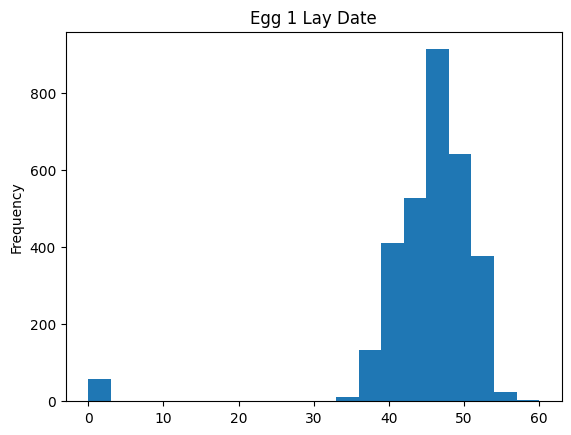

In [ ]:
penguin4['Egg 1 Lay Date'].plot(kind='hist', bins=20, title='Egg 1 Lay Date')

<Axes: title={'center': 'Egg 2 Lay Date'}, ylabel='Frequency'>

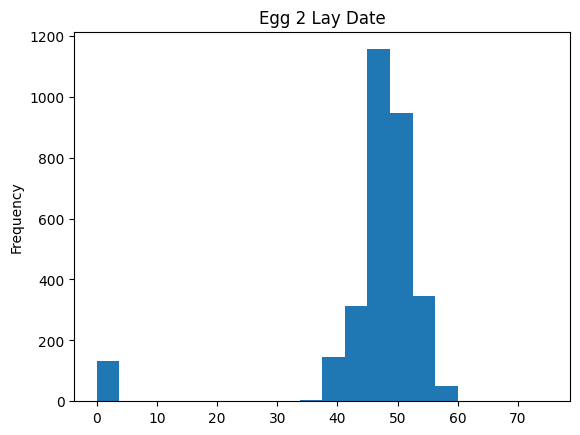

In [ ]:
penguin4['Egg 2 Lay Date'].plot(kind='hist', bins=20, title='Egg 2 Lay Date')

<Axes: title={'center': 'Egg 1 Loss Date'}, ylabel='Frequency'>

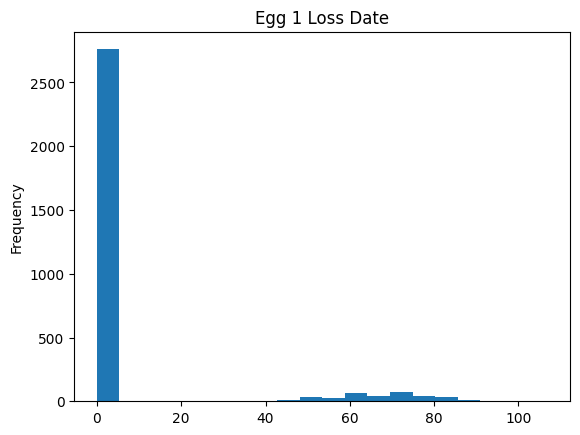

In [ ]:
penguin4['Egg 1 Loss Date'].plot(kind='hist', bins=20, title='Egg 1 Loss Date')

<Axes: title={'center': 'Egg 2 Loss Date'}, ylabel='Frequency'>

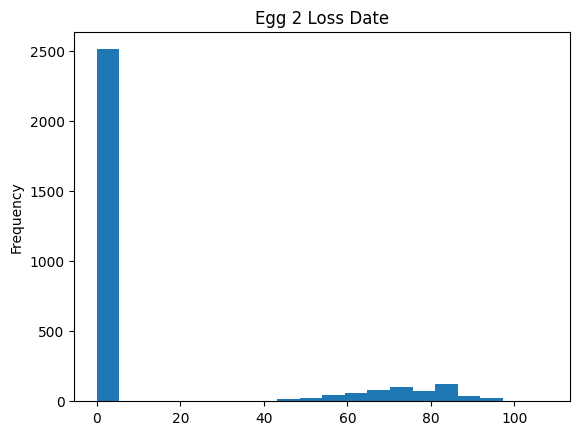

In [ ]:
penguin4['Egg 2 Loss Date'].plot(kind='hist', bins=20, title='Egg 2 Loss Date')

<Axes: title={'center': 'Chick 1 Hatch Date'}, ylabel='Frequency'>

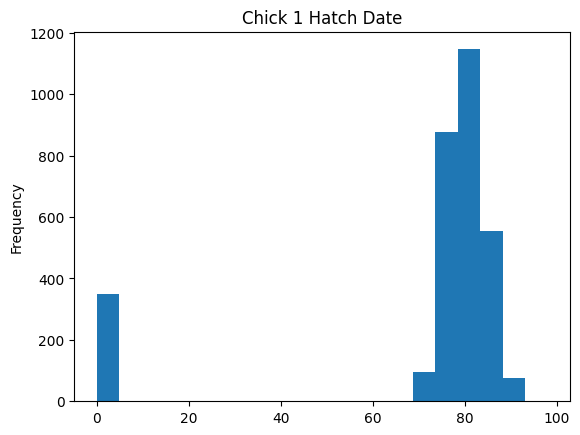

In [ ]:
penguin4['Chick 1 Hatch Date'].plot(kind='hist', bins=20, title='Chick 1 Hatch Date')

<Axes: title={'center': 'Chick 2 Hatch Date'}, ylabel='Frequency'>

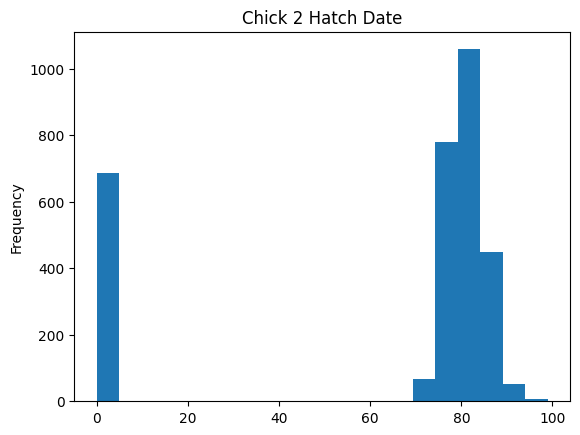

In [ ]:
penguin4['Chick 2 Hatch Date'].plot(kind='hist', bins=20, title='Chick 2 Hatch Date')

<Axes: title={'center': 'Chick 1 Loss Date'}, ylabel='Frequency'>

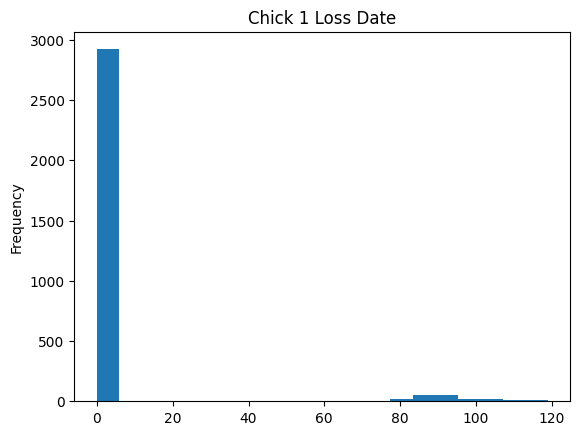

In [ ]:
penguin4['Chick 1 Loss Date'].plot(kind='hist', bins=20, title='Chick 1 Loss Date')

<Axes: title={'center': 'Chick 2 Loss Date'}, ylabel='Frequency'>

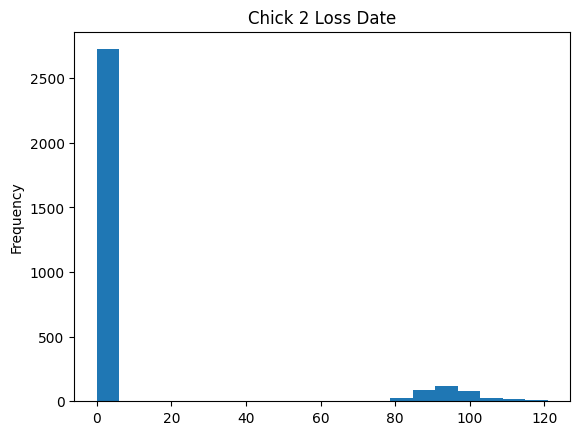

In [ ]:
penguin4['Chick 2 Loss Date'].plot(kind='hist', bins=20, title='Chick 2 Loss Date')

<Axes: title={'center': 'Chick 1 Creche Date'}, ylabel='Frequency'>

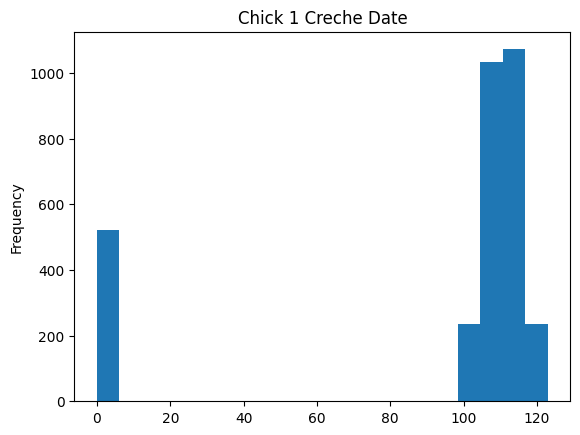

In [ ]:
penguin4['Chick 1 Creche Date'].plot(kind='hist', bins=20, title='Chick 1 Creche Date')

<Axes: title={'center': 'Chick 2 Creche Date'}, ylabel='Frequency'>

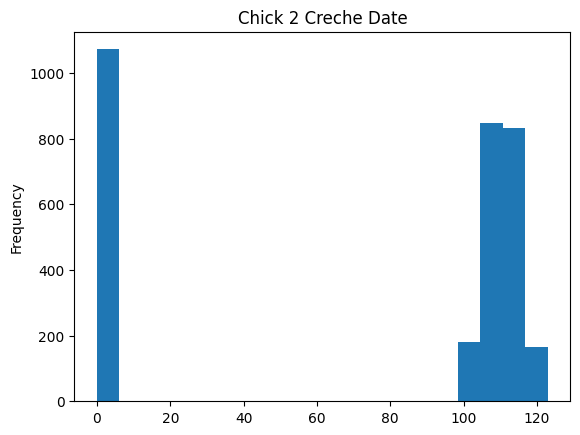

In [ ]:
penguin4['Chick 2 Creche Date'].plot(kind='hist', bins=20, title='Chick 2 Creche Date')

From the histograms, we observe the extend of 0 value entries: Loss values are almost never reported. Lay dates appear reasonable, in particular in view of the possibility that eggs were present/layed on October 1st. For everything else, we do observe the conundrum of having to issue for values corresponding to events not taking place.
As such, we do have to do a trade-off between potential features and misrepresenation. Considering the lack of data in all loss related columns, we will have to drop these later on (Action D). In view of the actual data contained in the other columns, we should keep 0 value entries for lay, hatch and creche events; however, we could complement these with binary categoricals (that is categories: Other egg present? Hatched? Creched?).

But let's take a step back and think about what we try to predict: Will a penguin reach crèche age? If we keep a crèche indicator, we already know the result. Similarly, if we keep a loss indicator, the opposite event already took place. These should not be fed into the model either way! For the hatch date, we would like to observe the actual date of hatching - without encoding the loss indicator by a value of 0. As such, it would make more sense to only observe the Loss and creche dates for the other egg accompagnying the observed egg, if present.

So, we need to standardize the layout of our data so to cite the data for the observed vs accompagnying egg in contrast to Egg 1 and Egg 2 data, so that we can drop the otherwise misleading columns later on. We also need to generate the binary classification for the event (Observed chick crèched).

In [ ]:
penguin4.head()

,studyName,Island,Colony,Site Number,Nest Number,Egg 1 Lay Date,Egg 2 Lay Date,Egg 1 Loss Date,Egg 2 Loss Date,Chick 1 Hatch Date,Chick 2 Hatch Date,Chick 1 Loss Date,Chick 2 Loss Date,Chick 1 Creche Date,Chick 2 Creche Date,Notes,Egg
0,PAL9192,HUM,2.0,1,1,44,47,0,0,79,80,0,0,107,107,NaN,1
1,PAL9192,HUM,2.0,1,2,49,52,0,0,85,87,0,0,111,111,NaN,1
2,PAL9192,HUM,2.0,1,3,46,49,0,0,82,83,0,0,107,107,NaN,1
3,PAL9192,HUM,2.0,1,4,49,52,0,0,85,86,0,0,111,114,NaN,1
4,PAL9192,HUM,2.0,1,5,45,48,0,0,79,80,0,0,111,112,NaN,1


In [ ]:
#Initialize columns
penguin4["Observed Lay Date"] = -1
penguin4["Other Lay Date"] = -1
penguin4["Observed Hatch Date"] = -1
penguin4["Other Hatch Date"] = -1
penguin4["Other Creche Date"] = -1
penguin4["Observed creching"] = False

In [ ]:
penguin4["Observed Lay Date"] = np.where((penguin4["Egg"] == 1), penguin4["Egg 1 Lay Date"], penguin4["Egg 2 Lay Date"])
penguin4["Other Lay Date"] = np.where((penguin4["Egg"] == 1), penguin4["Egg 2 Lay Date"], penguin4["Egg 1 Lay Date"])
penguin4["Observed Hatch Date"] = np.where((penguin4["Egg"] == 1), penguin4["Chick 1 Hatch Date"], penguin4["Chick 2 Hatch Date"])
penguin4["Other Hatch Date"] = np.where((penguin4["Egg"] == 1), penguin4["Chick 2 Hatch Date"], penguin4["Chick 1 Hatch Date"])
penguin4["Other Creche Date"] = np.where((penguin4["Egg"] == 1), penguin4["Chick 2 Creche Date"], penguin4["Chick 1 Creche Date"])

In [ ]:
penguin4["Observed creching"] = np.where((penguin4["Observed Hatch Date"] > 0), True, False)

Now all that remains is dropping all the obsolete, misleading or otherwise discussed columns:


1.   studyName does not have any relevant information and will be dropped
2.   Island contains only the same entry, as all data was collected on the same island, and will be dropped
3.   Colony, SiteNumber and NestNumber contain location information and might be relevant - these will be kept.
4.   Notes is irrelevant and will be dropped.
5.   Either original date not converted above will be dropped
6.   All remaining, created columns will be kept.



In [ ]:
penguin4.head()

,studyName,Island,Colony,Site Number,Nest Number,Egg 1 Lay Date,Egg 2 Lay Date,Egg 1 Loss Date,Egg 2 Loss Date,Chick 1 Hatch Date,...,Chick 1 Creche Date,Chick 2 Creche Date,Notes,Egg,Observed Lay Date,Other Lay Date,Observed Hatch Date,Other Hatch Date,Other Creche Date,Observed creching
0,PAL9192,HUM,2.0,1,1,44,47,0,0,79,...,107,107,NaN,1,44,47,79,80,107,True
1,PAL9192,HUM,2.0,1,2,49,52,0,0,85,...,111,111,NaN,1,49,52,85,87,111,True
2,PAL9192,HUM,2.0,1,3,46,49,0,0,82,...,107,107,NaN,1,46,49,82,83,107,True
3,PAL9192,HUM,2.0,1,4,49,52,0,0,85,...,111,114,NaN,1,49,52,85,86,114,True
4,PAL9192,HUM,2.0,1,5,45,48,0,0,79,...,111,112,NaN,1,45,48,79,80,112,True


In [ ]:
drop_rows = ["studyName", "Island", "Egg 1 Lay Date", "Egg 2 Lay Date", "Egg 1 Loss Date", "Egg 2 Loss Date", "Chick 1 Hatch Date", "Chick 2 Hatch Date", "Chick 1 Loss Date", "Chick 2 Loss Date", "Chick 1 Creche Date", "Chick 2 Creche Date", "Notes"]

In [ ]:
penguin5 = penguin4.drop(columns = drop_rows)

In [ ]:
penguin5.head()

,Colony,Site Number,Nest Number,Egg,Observed Lay Date,Other Lay Date,Observed Hatch Date,Other Hatch Date,Other Creche Date,Observed creching
0,2.0,1,1,1,44,47,79,80,107,True
1,2.0,1,2,1,49,52,85,87,111,True
2,2.0,1,3,1,46,49,82,83,107,True
3,2.0,1,4,1,49,52,85,86,114,True
4,2.0,1,5,1,45,48,79,80,112,True


In [ ]:
penguin5.shape

(3098, 10)

After data transformation, we end up with 3098 of our original (2 times 1756) 3512 effective rows. We do have to keep in mind that this was bought with keeping a lot of misleading 0 in the data, which might have some effects in terms of correlation. Before we continue on with more EDA, remember that everything so far was imported as a string, so let us quickly convert Colony, Site Number, Nest Number to categoricals and all other observations except the outcome to numericals:

In [98]:
penguin5["Colony"] = pd.Categorical(penguin5["Colony"])
penguin5["Site Number"] = pd.Categorical(penguin5["Site Number"])
penguin5["Nest Number"] = pd.Categorical(penguin5["Nest Number"])

In [ ]:
penguin5["Egg"] = pd.to_numeric(penguin5["Egg"])
penguin5["Other Creche Date"] = pd.to_numeric(penguin5["Other Creche Date"])
penguin5["Other Hatch Date"] = pd.to_numeric(penguin5["Other Hatch Date"])
penguin5["Observed Hatch Date"] = pd.to_numeric(penguin5["Observed Hatch Date"])
penguin5["Other Lay Date"] = pd.to_numeric(penguin5["Other Lay Date"])
penguin5["Observed Lay Date"] = pd.to_numeric(penguin5["Observed Lay Date"])

In [ ]:
#Reordering columns so that outcome is placed first:
cols = list(penguin5.columns)
cols.reverse()

In [ ]:
corr = penguin5[cols].corr(numeric_only=True)

corr

,Observed creching,Other Creche Date,Other Hatch Date,Observed Hatch Date,Other Lay Date,Observed Lay Date,Egg
Observed creching,1.000000,0.447658,0.572672,0.992123,0.053869,-0.093059,-0.110144
Other Creche Date,0.447658,1.000000,0.755951,0.443283,0.123104,-0.025253,0.230757
Other Hatch Date,0.572672,0.755951,1.000000,0.576021,0.214064,0.000408,0.167822
Observed Hatch Date,0.992123,0.443283,0.576021,1.000000,0.091691,-0.032549,-0.097773
Other Lay Date,0.053869,0.123104,0.214064,0.091691,1.000000,0.652597,-0.004583
Observed Lay Date,-0.093059,-0.025253,0.000408,-0.032549,0.652597,1.000000,0.151028
Egg,-0.110144,0.230757,0.167822,-0.097773,-0.004583,0.151028,1.000000


<Axes: >

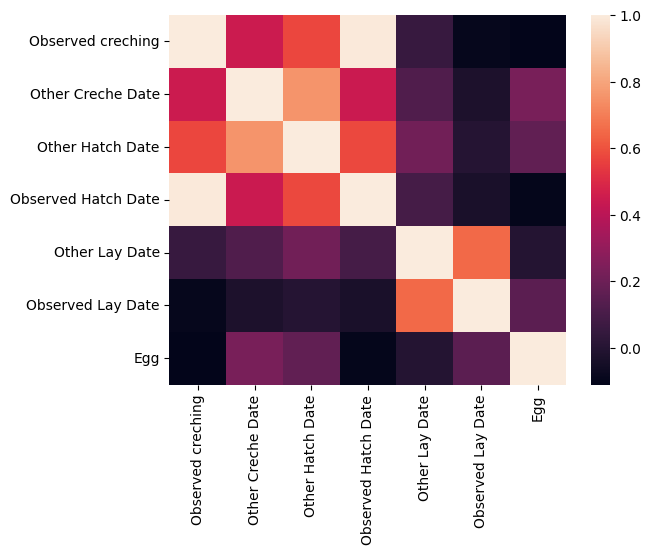

In [ ]:
sns.heatmap(corr)

As can be seen from the heatmap visualization, the observed creching is highly correlated with the observed hatch date (nearly 1), and somewhat correlated with the other eggs creche and hatch date (between .4 and .6). It appears that the other lay date and the observed lay date do not suggest a correlation or only a weak correlation. In view of this, it is rather unsurprising that other creche and other hatch date are correlated as well (as these would be the observed values for the other egg when places are switched).
A bit to the surprising side, the Egg number under observation does not yield a correlation to the observed creching.

Before venturing forth to creating our model, we should at least take another glance at how good these correlations are with a basic statistical test. We use the pearson correlation coefficient function found in the scipy.stats library to determine the correlation coefficient (a bit redundant in view of the above...) and the p value. Setting a p value of .05 for our confidence level, we get the following for each feature's correlation with the binary outcome:

In [ ]:
coeff, pval = scipy.stats.pearsonr(penguin5["Observed creching"], penguin5["Egg"])
print("Egg: " + str(coeff) + " and " + str(pval))
coeff, pval = scipy.stats.pearsonr(penguin5["Observed creching"], penguin5["Observed Lay Date"])
print("Observed lay date: " + str(coeff) + " and " + str(pval))
coeff, pval = scipy.stats.pearsonr(penguin5["Observed creching"], penguin5["Observed Hatch Date"])
print("Observed hatch date: " + str(coeff) + " and " + str(pval))
coeff, pval = scipy.stats.pearsonr(penguin5["Observed creching"], penguin5["Other Hatch Date"])
print("Other hatch date: " + str(coeff) + " and " + str(pval))
coeff, pval = scipy.stats.pearsonr(penguin5["Observed creching"], penguin5["Other Lay Date"])
print("Other lay date: " + str(coeff) + " and " + str(pval))
coeff, pval = scipy.stats.pearsonr(penguin5["Observed creching"], penguin5["Other Creche Date"])
print("Other creche date: " + str(coeff) + " and " + str(pval))

Egg: -0.11014385056347434 and 7.905817965529997e-10
Observed lay date: -0.09305936591495272 and 2.1162297555804188e-07
Observed hatch date: 0.992122774034241 and 0.0
Other hatch date: 0.5726719214025962 and 1.6324331151248847e-269
Other lay date: 0.05386910692162136 and 0.0027059622137935485
Other creche date: 0.44765843814734985 and 1.4245859723287572e-152


So all correlations are significant with the chosen level of significance. What about the other categoricals that did not fit into the correlation map above? Well, we cannot proceed and calculate pearson regression between non-ordinal categoricals. However, we can have a short look at mean and standard deviation for the binary outcome grouped for each category. Setting a weak signficance level of 1 SD for category comparison to err on the safe side, we get:

In [ ]:
#We need to quickly convert the boolean outcome back to a numerical value:
penguin_test = penguin5
penguin_test["Eval"] = -1
penguin_test["Eval"] = np.where((penguin_test["Observed creching"] == True), 1, 0)

In [ ]:
penguin5.groupby("Colony")["Eval"].describe()

,count,mean,std,min,25%,50%,75%,max
Colony,,,,,,,,
1.1,3.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0
1.2,10.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0
1.3,6.0,0.333333,0.516398,0.0,0.0,0.0,0.75,1.0
2.0,1819.0,0.837823,0.368714,0.0,1.0,1.0,1.00,1.0
2.1,28.0,0.928571,0.262265,0.0,1.0,1.0,1.00,1.0
2.2,126.0,0.888889,0.315524,0.0,1.0,1.0,1.00,1.0
3.0,453.0,0.860927,0.346405,0.0,1.0,1.0,1.00,1.0
3.1,31.0,0.645161,0.486373,0.0,0.0,1.0,1.00,1.0
4.0,272.0,0.838235,0.368914,0.0,1.0,1.0,1.00,1.0


In [ ]:
penguin5.groupby("Site Number")["Eval"].describe()

,count,mean,std,min,25%,50%,75%,max
Site Number,,,,,,,,
0,10.0,1.000000,0.000000,1.0,1.00,1.0,1.0,1.0
1,526.0,0.826996,0.378611,0.0,1.00,1.0,1.0,1.0
10,104.0,0.846154,0.362548,0.0,1.00,1.0,1.0,1.0
11,59.0,0.881356,0.326145,0.0,1.00,1.0,1.0,1.0
12,33.0,0.727273,0.452267,0.0,0.00,1.0,1.0,1.0
13,35.0,0.914286,0.284029,0.0,1.00,1.0,1.0,1.0
14,38.0,0.815789,0.392859,0.0,1.00,1.0,1.0,1.0
15,34.0,0.735294,0.447811,0.0,0.25,1.0,1.0,1.0
16,27.0,0.666667,0.480384,0.0,0.00,1.0,1.0,1.0


In [ ]:
penguin5.groupby("Nest Number")["Eval"].describe()

,count,mean,std,min,25%,50%,75%,max
Nest Number,,,,,,,,
1,599.0,0.732888,0.442821,0.0,0.0,1.0,1.0,1.0
2,611.0,0.851064,0.356317,0.0,1.0,1.0,1.0,1.0
3,630.0,0.863492,0.343600,0.0,1.0,1.0,1.0,1.0
4,623.0,0.876404,0.329384,0.0,1.0,1.0,1.0,1.0
5,631.0,0.868463,0.338255,0.0,1.0,1.0,1.0,1.0
6,4.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


Well, even when using only 1 SD enviroments, the different categories would overlap in terms of their outcome. As such, it appears that the categorical location variables are not statistically significantly different from each other. We do keep them, however, for the time being, e. g. for further model evaluations.

One minor point we can still address is the point of (lack of) symmetry, now that we have our data in order - how is the balance of features in view of the outcome? And is the default outcome biased towards survival or not?

In [ ]:
penguin5["Eval"].describe()

count    3098.000000
mean        0.839574
std         0.367060
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Eval, dtype: float64

<Axes: ylabel='Frequency'>

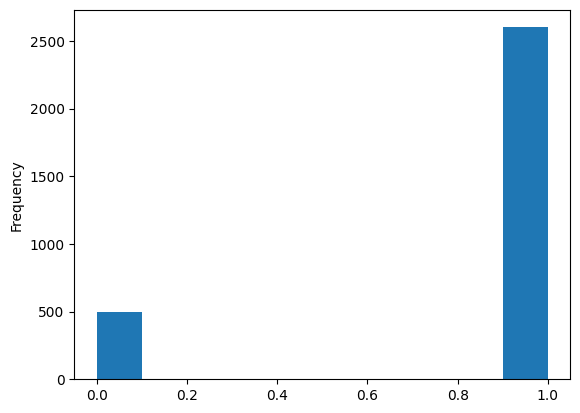

In [ ]:
penguin5["Eval"].plot.hist()

So, as we might have guessed from previous plots and analysis already, the mean of our values is approx. 0.84, so of the 3098 remaining cases for individual eggs 1 and eggs 2, 84% reach the crèche phase. So our data set is already biased towards the success - one thing we need to consider for our model evaluation!

In [ ]:
#For the time being, we keep the Eval column for further plots downstream
#penguin5 = penguin5.drop(columns = ["Eval"])

# Model selection, training and evaluation

### The reference model: Generalized Additive Model (GAM)

So, now that we have decided on our features and, maybe sounding like a broken record: Keeping in mind the asymmetry of outcome and the non-linearity in particular in view of the encoded 0s in the dataset, before starting off with a ensemble classification, one should pick a reference model that is at least somewhat capable of adjusting for these particularities.
A Generalized Additive Model might be a good way of not only seeing the contribution of every predictor to the classifiers success, but also allows for smoothing with non-parametric smoothing functions so adjust for non-linearity. We need to keep in mind that GAMs have a tendency of overfitting if not applied carefully, so we should definitely test our prediction on a holdout set!

Let us however first create a simple 80/20 split into train/testing data.

In [ ]:
penguin_train, penguin_test = train_test_split(penguin5, train_size = .8)

In [ ]:
print("Length of train and test data is: " +str(len(penguin_train)) + " and " + str(len(penguin_test)))

Length of train and test data is: 2478 and 620


In [94]:
X_train_full = penguin_train[["Colony","Site Number","Nest Number","Egg","Observed Lay Date","Other Lay Date","Observed Hatch Date","Other Hatch Date","Other Creche Date"]]
X_test_full = penguin_test[["Colony","Site Number","Nest Number","Egg","Observed Lay Date","Other Lay Date","Observed Hatch Date","Other Hatch Date","Other Creche Date"]]


X_train_dates = penguin_train[["Egg","Observed Lay Date","Other Lay Date","Observed Hatch Date","Other Hatch Date","Other Creche Date"]]
X_test_dates = penguin_test[["Egg","Observed Lay Date","Other Lay Date","Observed Hatch Date","Other Hatch Date","Other Creche Date"]]

Y_train = penguin_train[["Observed creching"]]
Y_test = penguin_test[["Observed creching"]]

X_all_dates = penguin5[["Egg","Observed Lay Date","Other Lay Date","Observed Hatch Date","Other Hatch Date","Other Creche Date"]]
X_all_full = penguin5[["Colony","Site Number","Nest Number","Egg","Observed Lay Date","Other Lay Date","Observed Hatch Date","Other Hatch Date","Other Creche Date"]]
Y_all = penguin5[["Observed creching"]]

In [ ]:
penguin5.head()

,Colony,Site Number,Nest Number,Egg,Observed Lay Date,Other Lay Date,Observed Hatch Date,Other Hatch Date,Other Creche Date,Observed creching,Eval
0,2.0,1,1,1,44,47,79,80,107,True,1
1,2.0,1,2,1,49,52,85,87,111,True,1
2,2.0,1,3,1,46,49,82,83,107,True,1
3,2.0,1,4,1,49,52,85,86,114,True,1
4,2.0,1,5,1,45,48,79,80,112,True,1


Without knowledge of whether one of the predictors might attribute linearly, we apply automatically chosen smoothing functions for each predictor. Since this is a classification problem, we need to use the LogisitcGAM function

In [ ]:
GAM_dates = pygam.LogisticGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5)).fit(X_train_dates, Y_train) #Logistic

In [ ]:
GAM_dates

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + intercept, 
   tol=0.0001, verbose=False)

In [ ]:
GAM_dates.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      5.9371
Link Function:                        LogitLink Log Likelihood:                                       -0.0
Number of Samples:                         2478 AIC:                                               11.8741
                                                AICc:                                              11.9187
                                                UBRE:                                               2.0067
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                      1.0
Feature Function                  Lam

<ipython-input-66-638c3955894b>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  GAM_dates.summary()


Knowing that having DOF around 1 could be a good indicator for a predictor entering linearily instead of going through a smoothing function first, we might want to reconsider smoothing features 1 and 2, that is both hatching dates.

In [ ]:
GAM_dates = pygam.LogisticGAM(s(0) + l(1) + l(2) + s(3) + s(4) + s(5)).fit(X_train_dates, Y_train) #Logistic

In [ ]:
GAM_dates.accuracy(X_train_dates, Y_train)

1.0

In [ ]:
GAM_dates.accuracy(X_test_dates, Y_test)

1.0

We could at this point stop and assume that our model is already given us the best accuracy to hope for (which means that precision and recall in absence of false positives or negatives are also both 1) - however, remember the imbalance in the data clearly favouring the positive outcome? Lets do a quick check of the confusion matrix

In [ ]:
predict_dates = GAM_dates.predict(X_test_dates)

In [ ]:
#predict_dates

In [ ]:
conf_dates = sklearn.metrics.confusion_matrix(Y_test, predict_dates)
conf_dates

array([[106,   0],
       [  0, 514]])

Text(0.5, 23.52222222222222, 'Observed')

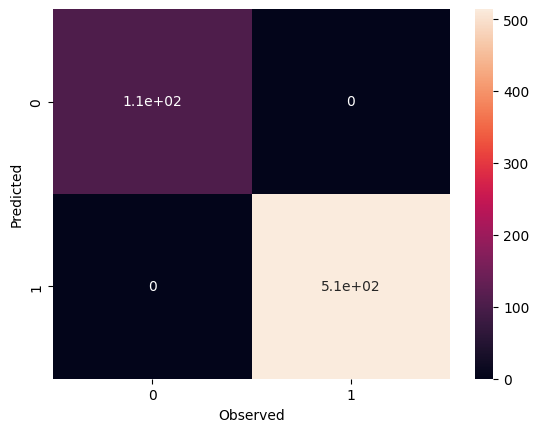

In [ ]:
plt.plot()
sns.heatmap(conf_dates, annot=True)
plt.ylabel("Predicted")
plt.xlabel("Observed")

Well, we indeed observe the expected asymmetry in the observed classes - nontheless, we have optimal prediction accuracy achieved without tuning. Normally, we would would perform some sort of parameter tuning (that is, perform a search for the optimal smoothing function parameter lambda), but this is rendered moot by the results above. What we still could do in anticipation of the feature selection for the ensemble methods would be to look at the individual contributions of each predictor. If we were discussing a regression model, this could be done by plotting partial dependence functions, e. g. as presented in PYGAM documentation provided here: https://pygam.readthedocs.io/en/latest/notebooks/quick_start.html#Fit-a-Model, item  [21]. However, this would not yield any meaningful plots for our classification problem.

Since we already achieve perfect prediction accuracy on the testing set (and we do not easily access correct statistical indicators for the LogisticGAM), we can look to try to create reduced models and see whether they perform similarly. Let's start by taking the hatching and creching dates, which are known to be at least somewhat correlated with the outcome, and use them exclusively for the GAM.

In [ ]:
GAM_dates_red = pygam.LogisticGAM(s(3) + s(4) + s(5)).fit(X_train_dates, Y_train) #Logistic

In [ ]:
GAM_dates_red.accuracy(X_test_dates, Y_test)

1.0

In [ ]:
predict_dates_red = GAM_dates_red.predict(X_test_dates)
conf_dates_red = sklearn.metrics.confusion_matrix(Y_test, predict_dates_red)
conf_dates_red

array([[106,   0],
       [  0, 514]])

As to be expected, our prediction does not change when using only the predictors with the highest correlation with the outcome. Since accuracy, precision and recall remain 1, we do not have any indication to keep the full model. Can we reduce our reference model further?

In [ ]:
GAM_dates_crech = pygam.LogisticGAM(s(5)).fit(X_train_dates, Y_train) #Logistic

In [ ]:
GAM_dates_crech.accuracy(X_test_dates, Y_test)

0.8290322580645161

In [ ]:
GAM_dates_hatch1_2 = pygam.LogisticGAM(s(3) + s(4)).fit(X_train_dates, Y_train) #Logistic

In [ ]:
GAM_dates_hatch1_2.accuracy(X_test_dates, Y_test)

1.0

In [ ]:
GAM_dates_hatch1 = pygam.LogisticGAM(s(3)).fit(X_train_dates, Y_train) #Logistic

In [ ]:
GAM_dates_hatch1.accuracy(X_test_dates, Y_test)

1.0

In [222]:
GAM_dates_hatch2 = pygam.LogisticGAM(s(4)).fit(X_train_dates, Y_train) #Logistic

In [223]:
GAM_dates_hatch2.accuracy(X_test_dates, Y_test)

0.8790322580645161

As it turns out, we keep our prediction accuracy simply when keeping the observed eggs hatching status. How does that model look like in detail?

In [ ]:
GAM_dates_hatch1.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      1.9473
Link Function:                        LogitLink Log Likelihood:                                       -0.0
Number of Samples:                         2478 AIC:                                                3.8946
                                                AICc:                                                3.904
                                                UBRE:                                               2.0022
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                      1.0
Feature Function                  Lam

<ipython-input-85-4e744507e13c>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  GAM_dates_hatch1.summary()


In [ ]:
predict_dates_hatch1 = GAM_dates_hatch1.predict(X_test_dates)
conf_dates_hatch1 = sklearn.metrics.confusion_matrix(Y_test, predict_dates_hatch1)
conf_dates_hatch1

array([[106,   0],
       [  0, 514]])

Since the GAM here is only used as a reference model, we could (!) stop here - we do know that we can use this GAM classifier trained on only the hatching date of an observed egg to correctly predict all instances in our data. Since we do have plenty of entries where chicks were lost, we have already gained a valuable insight - it appears that the hatching date is the predominant facor of successfully reaching a crèching age!

But didn't we say that we have to watch out for our asymmetry? How to address this? Maybe we should take a few steps back and employ cross-validation - specifically, stratified k-fold cross-validation, as otherwise, our imbalance would probably just increase. We use the cross_validation function of sklearn for it with cv = 10, as this employs stratified k-fold (see documentation, in particular "For int/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used.", https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html).

In [ ]:
GAM_dates_hatch1 = pygam.LogisticGAM()
sklearn.model_selection.cross_validate(GAM_dates_hatch1, X_all_dates[["Observed Hatch Date"]], Y_all, cv = 10, scoring=["accuracy", "recall", "precision"])

{'fit_time': array([0.3442347 , 0.36465263, 0.415133  , 0.48888278, 0.59303641,
        0.60254979, 0.57092214, 0.56968594, 0.30701518, 0.39524126]),
 'score_time': array([0.03733253, 0.05446291, 0.09277177, 0.12776303, 0.14426613,
        0.10107374, 0.10108972, 0.04695559, 0.11939025, 0.08069587]),
 'test_accuracy': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'test_recall': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'test_precision': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}

In [ ]:
GAM_dates = pygam.LogisticGAM()
sklearn.model_selection.cross_validate(GAM_dates, X_all_dates[["Egg","Observed Lay Date","Other Lay Date","Observed Hatch Date","Other Hatch Date","Other Creche Date"]], Y_all, cv = 10, scoring=["accuracy", "recall", "precision"])

{'fit_time': array([3.45745707, 2.77547741, 3.21335196, 4.01215363, 2.58979368,
        2.61922526, 1.31244493, 1.24612498, 2.29978561, 1.60432458]),
 'score_time': array([0.09920955, 0.08307028, 0.14655924, 0.08688235, 0.04040313,
        0.04723573, 0.0354929 , 0.03571939, 0.04993343, 0.03933477]),
 'test_accuracy': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'test_recall': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'test_precision': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}

In [ ]:
GAM_dates_crech = pygam.LogisticGAM()
sklearn.model_selection.cross_validate(GAM_dates_crech, X_all_dates[["Other Creche Date"]], Y_all, cv = 10, scoring=["accuracy", "recall", "precision"])

{'fit_time': array([0.06756639, 0.05508661, 0.06383085, 0.05841708, 0.05695772,
        0.05798984, 0.05578423, 0.05364728, 0.06077743, 0.0552783 ]),
 'score_time': array([0.03100061, 0.02820659, 0.05293298, 0.03036737, 0.02856374,
        0.02835941, 0.03401852, 0.02897   , 0.03530574, 0.02932906]),
 'test_accuracy': array([0.87741935, 0.87419355, 0.91935484, 0.84193548, 0.87096774,
        0.78709677, 0.83870968, 0.81290323, 0.77993528, 0.79288026]),
 'test_recall': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'test_precision': array([0.87741935, 0.87419355, 0.91935484, 0.84193548, 0.87096774,
        0.78709677, 0.83870968, 0.81290323, 0.77993528, 0.79288026])}

In [ ]:
GAM_dates_test = pygam.LogisticGAM()
sklearn.model_selection.cross_validate(GAM_dates_test, X_all_dates[["Other Lay Date"]], Y_all, cv = 10, scoring=["accuracy", "recall", "precision"])

{'fit_time': array([0.05902433, 0.05551076, 0.0571177 , 0.08139348, 0.05517125,
        0.05687475, 0.05442739, 0.05927324, 0.05908036, 0.06150293]),
 'score_time': array([0.02969933, 0.03128934, 0.04076338, 0.03422117, 0.02857804,
        0.03380227, 0.02789664, 0.02919245, 0.03055668, 0.03353548]),
 'test_accuracy': array([0.87741935, 0.87419355, 0.91935484, 0.84193548, 0.87096774,
        0.78709677, 0.83870968, 0.81290323, 0.77993528, 0.79288026]),
 'test_recall': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'test_precision': array([0.87741935, 0.87419355, 0.91935484, 0.84193548, 0.87096774,
        0.78709677, 0.83870968, 0.81290323, 0.77993528, 0.79288026])}

Well, apparently, even when using the whole data set and performing 10 cross-validations, we still achieve full accuracy (as well as recall and precision) with just using the observed hatch date for each iteration! (Similarly, we do not have any misclassification when using all dates as predictors). So, now that we have addressed also potentialy asymmetry-based pitfalls (we need not implement any over or undersampling in view of no classification errors and therefore no asymmetry between type I and type II errors), we set this model as the reference and proceed to our ensemble methods.

Anticipating dropping the best predictor later on, we also construc a 2nd reference model without the observed hatching:

In [230]:
GAM_dates_nohatch1 = pygam.LogisticGAM(s(0) + l(1) + l(2) + s(4) + s(5)).fit(X_train_dates, Y_train) #Logistic
GAM_dates_nohatch1.accuracy(X_test_dates, Y_test)

0.867741935483871

In [231]:
GAM_dates_nohatch1.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     10.6472
Link Function:                        LogitLink Log Likelihood:                                  -616.0038
Number of Samples:                         2478 AIC:                                             1253.3019
                                                AICc:                                            1253.4214
                                                UBRE:                                               2.5092
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.4298
Feature Function                  Lam

<ipython-input-231-e7d7eec0a27b>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  GAM_dates_nohatch1.summary()


In this context, it does seem as if the observed lay dates should enter linearily still, but are not statistically significant. So let us drop them and re-evaluate our model:

In [232]:
GAM_dates_nohatch1 = pygam.LogisticGAM(s(0) + s(4) + s(5)).fit(X_train_dates, Y_train) #Logistic
GAM_dates_nohatch1.accuracy(X_test_dates, Y_test)

0.8709677419354839

In [233]:
GAM_dates_nohatch1.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      8.6468
Link Function:                        LogitLink Log Likelihood:                                  -616.6696
Number of Samples:                         2478 AIC:                                             1250.6327
                                                AICc:                                            1250.7159
                                                UBRE:                                               2.5075
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.4292
Feature Function                  Lam

<ipython-input-233-e7d7eec0a27b>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  GAM_dates_nohatch1.summary()


So our second reference model achieves a prediction accuracy of ca. 0.88. But what about type I and II errors?

In [234]:
predict_dates = GAM_dates_nohatch1.predict(X_test_dates)
conf_dates = sklearn.metrics.confusion_matrix(Y_test, predict_dates)
conf_dates


array([[ 27,  79],
       [  1, 513]])

Text(0.5, 27.52222222222222, 'Observed')

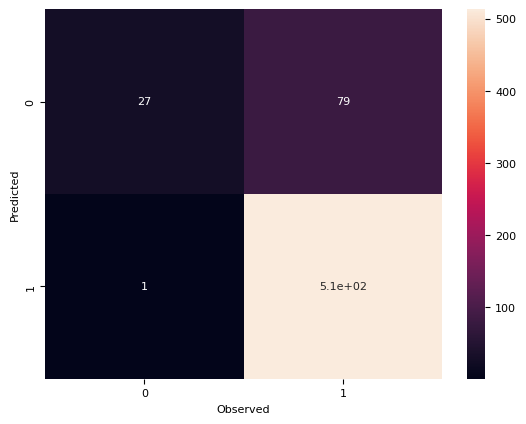

In [235]:
plt.plot()
sns.heatmap(conf_dates, annot=True)
plt.ylabel("Predicted")
plt.xlabel("Observed")

Considering the data imbalance, our accuracy is bought by grossly misclassifying negative crèching outcomes! Let us see what our reference recall and precision are for the 2nd reference model

In [241]:
TP = conf_dates[0][0]
FP = conf_dates[1][0]
FN = conf_dates[0][1]
TN = conf_dates[1][1]
prec = TP/(TP+FP)
rec = TP/(TP+FN)
print("Recall is " +str(rec) +" and precision is: " +str(prec))

Recall is 0.25471698113207547 and precision is: 0.9642857142857143


In [247]:
GAM_dates_nohatch1 = pygam.LogisticGAM()
GAM_dates_nohatch1_CV = sklearn.model_selection.cross_validate(GAM_dates, X_all_dates[["Egg","Observed Lay Date","Other Lay Date","Other Hatch Date","Other Creche Date"]], Y_all, cv = 10, scoring=["accuracy", "recall", "precision"])
GAM_dates_nohatch1_CV

{'fit_time': array([0.40207839, 0.39304423, 0.40830803, 0.30037141, 0.31234264,
        0.38950443, 0.33552361, 0.35781527, 0.3382144 , 0.35467529]),
 'score_time': array([0.03496289, 0.03997731, 0.03473735, 0.0371244 , 0.04391074,
        0.03727126, 0.03394103, 0.04112005, 0.03998423, 0.09441376]),
 'test_accuracy': array([0.86774194, 0.88709677, 0.88387097, 0.86774194, 0.8516129 ,
        0.87419355, 0.92903226, 0.89032258, 0.90614887, 0.87702265]),
 'test_recall': array([0.92647059, 0.9704797 , 0.89122807, 0.98467433, 0.88148148,
        0.98770492, 1.        , 1.        , 0.99170124, 0.99183673]),
 'test_precision': array([0.92307692, 0.90689655, 0.98069498, 0.87414966, 0.94444444,
        0.8700361 , 0.92198582, 0.88111888, 0.89849624, 0.87096774])}

In [250]:
print("CV test accuracy is: " +str(GAM_dates_nohatch1_CV["test_accuracy"].mean()))
print("CV test recall is: " +str(GAM_dates_nohatch1_CV["test_recall"].mean()))
print("CV test precision is: " +str(GAM_dates_nohatch1_CV["test_precision"].mean()))

CV test accuracy is: 0.8834784424261406
CV test recall is: 0.9625577071731121
CV test precision is: 0.907186734014617


### Ensemble methods

We have already some idea of the feature ranking from the EDA and the reference model (that is, observed hatching date being the strongest predictor, sufficient to explain the outcome on its own, followed by somewhat correlated predictors of the other chick crèching date or the other egg hatching date, and all other indicators being uncorrelated or so weakly correlated that they do not provide sufficient explanatory potential by themselves).

But we established that hierachy of features e. g. merely based on correlations. What if we really wanted to see the predictive potential of every feature in the data set? One ensemble method that would give us the possibility would be a Random Forest, as it is decorrelating features. It also provides for cross-validation. Maybe we see the predictive potential of "earlier" features, i.e. features that occurr earlier in the life of a penguin? Let's find out.

We start off by first looking at a RF without any parameters pre-defined (e. g. no tree depth)

In [108]:
penguin_RF = RandomForestClassifier()
#p_RF_fit = penguin_RF.fit(X_all_dates, Y_all.values.ravel())
p_RF_fit = penguin_RF.fit(X_train_dates, Y_train.values.ravel())

In [110]:
#p_RF_fit.score(X_all_dates,Y_all.values.ravel())
p_RF_fit.score(X_test_dates,Y_test.values.ravel())

1.0

No surprise here - our prediction accuracy is again 1 (and so are recall and precision). But what about our feature importance we have been looking for?

In [130]:
p_RF_importances = p_RF_fit.feature_importances_

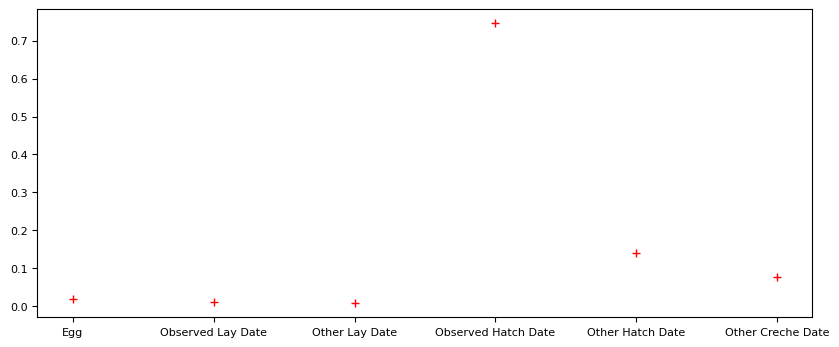

In [131]:
xdata = ["Egg","Observed Lay Date","Other Lay Date","Observed Hatch Date","Other Hatch Date","Other Creche Date"]
font = {'size': 8}

plt.matplotlib.rc('font', **font)
plt.figure(figsize=(10, 4))
plt.plot(xdata, p_RF_importances, "r+")

So the absolute Gini importances do show the same result as for our previous analysis: Most important for our prediction is the hatch date, followed by the other eggs hatch date and the other creche date. All remaining features do not contribute much to the impurity-based importance. Let's do a more substantial plot of this using the method as presented for Scikits plot_forest_importances method documentation as described here: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html (section: "Feature importance based on mean decrease in impurity" - there is no built in function for this functionality). What it does is plot us the already present "mean and standard deviation of accumulation of the impurity decrease within each tree" for each feature.

Text(0, 0.5, 'Mean decrease in impurity')

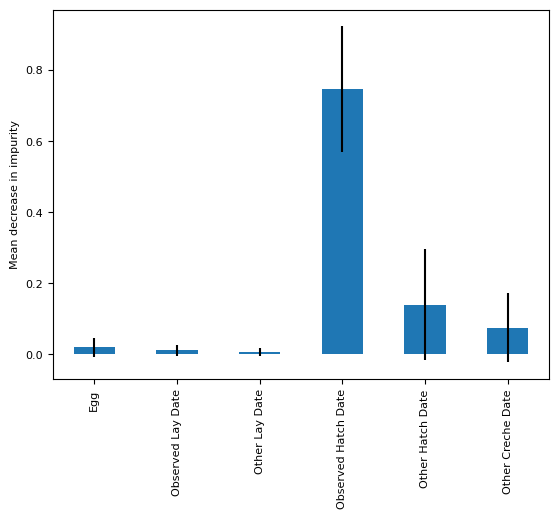

In [138]:
p_RF_importance = pd.Series(p_RF_importances, index=xdata)
std = np.std([tree.feature_importances_ for tree in p_RF_fit.estimators_], axis=0)
fig, ax = plt.subplots()

p_RF_importance.plot.bar(yerr=std, ax=ax)

ax.set_ylabel("Mean decrease in impurity")

So, while in absolute terms the mean decrease in impunity might be considered relevant for the other hatch and creche dates, the standard deviation paint a slightly different picture. Let's supplement this with a similar plot for accuracy decrease (again, we use the method provided by Scikit's documentation, section "Feature importance based on feature permutation", https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html). We can perform this method on the holdout set!

In [151]:
p_perm_importance = permutation_importance(p_RF_fit, X_test_dates, Y_test, n_repeats=10)
forest_importances = pd.Series(p_perm_importance.importances_mean, index=xdata)

Text(0, 0.5, 'Mean accuracy decrease')

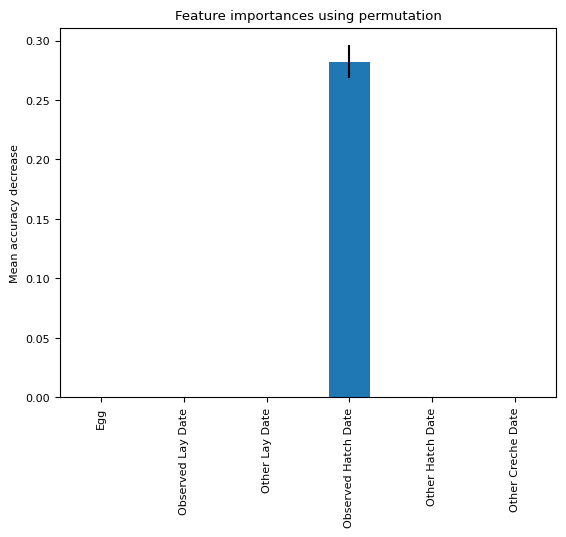

In [152]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=p_perm_importance.importances_std, ax=ax)
ax.set_title("Feature importances using permutation")
ax.set_ylabel("Mean accuracy decrease")

So in regards to mean accuracy decrease, the other hatch and other creche date are irrelevant (though we have to keep in mind that this method can tend to omit features completely). Together with the mean decrease in impurity, it actually appears that hatching is all we need for our model (which does render all analysis from here on a bit tedious and boring...).
What happens if we only observe the other egg's fate and both lay dates?

In [189]:
penguin_RF_other = RandomForestClassifier()
xdata2 = ["Egg","Observed Lay Date","Other Lay Date","Other Hatch Date","Other Creche Date"]
p_RF_fit_other = penguin_RF_other.fit(X_train_dates[xdata2], Y_train.values.ravel())

p_RF_fit_other.score(X_test_dates[xdata2],Y_test.values.ravel())

0.8629032258064516

With this result, we can work - the starting accuracy for a RF without any parameter constrains is approx. 0.86. Let's do a quick cross_validation so to again also consider the data imbalance:

In [180]:
penguin_RF_other_CV = sklearn.model_selection.cross_validate(penguin_RF_other, X_all_dates[xdata2], Y_all.values.ravel(), cv = 10, scoring=["accuracy", "recall", "precision"])

In [181]:
penguin_RF_other_CV

{'fit_time': array([0.31297708, 0.3141222 , 0.32428741, 0.30118656, 0.46503711,
        0.46072555, 0.45011044, 0.49040842, 0.45589995, 0.33325076]),
 'score_time': array([0.01355696, 0.02134275, 0.01377749, 0.01595306, 0.01957798,
        0.02594399, 0.02551389, 0.02783585, 0.02587581, 0.01406837]),
 'test_accuracy': array([0.86451613, 0.84193548, 0.79032258, 0.82258065, 0.81612903,
        0.76451613, 0.76129032, 0.6516129 , 0.84789644, 0.77993528]),
 'test_recall': array([0.96168582, 0.94230769, 0.87307692, 0.92692308, 0.88076923,
        0.80769231, 0.84230769, 0.63076923, 0.92307692, 0.84230769]),
 'test_precision': array([0.8869258 , 0.8781362 , 0.87644788, 0.8700361 , 0.89803922,
        0.90128755, 0.86904762, 0.93181818, 0.8988764 , 0.8902439 ])}

In [172]:
print("Mean test accuracy is: " + str(penguin_RF_other_CV["test_accuracy"].mean()))
print("Mean test recall is: " + str(penguin_RF_other_CV["test_recall"].mean()))
print("Mean test precision is: " + str(penguin_RF_other_CV["test_precision"].mean()))

Mean test accuracy is: 0.7937467376552876
Mean test recall is: 0.8638594164456235
Mean test precision is: 0.8891631417595548


On a side not, here we do observe that the accuracy using our fixed split not adjusting for imbalance would be an over-estimation!

How is our feature importance for this RF looking like? (Again, using the methods as provided in the Scikit documentation linked above)

Text(4.444444444444445, 0.5, 'Mean decrease in impurity')

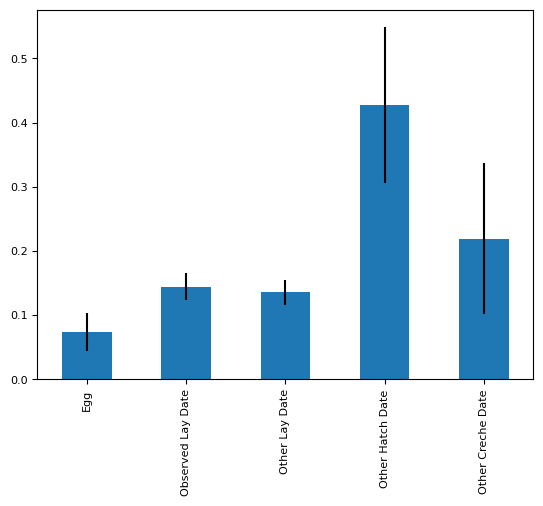

In [186]:
p_RF_other_importances = p_RF_fit_other.feature_importances_
p_RF_other_importance = pd.Series(p_RF_other_importances, index=xdata2)
std2 = np.std([tree.feature_importances_ for tree in p_RF_fit_other.estimators_], axis=0)
fig2, ax2 = plt.subplots()

p_RF_other_importance.plot.bar(yerr=std2, ax=ax2)

ax.set_ylabel("Mean decrease in impurity")

Text(0, 0.5, 'Mean accuracy decrease')

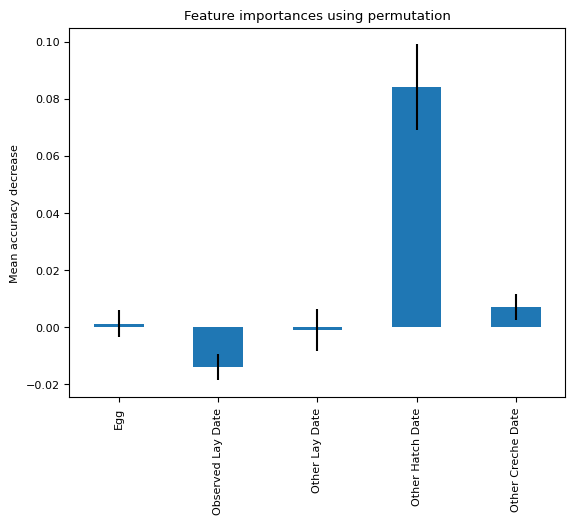

In [188]:
p_perm_importance_other = permutation_importance(p_RF_fit_other, X_test_dates[xdata2], Y_test, n_repeats=10)
forest_importances_other = pd.Series(p_perm_importance_other.importances_mean, index=xdata2)
fig, ax = plt.subplots()
forest_importances_other.plot.bar(yerr=p_perm_importance_other.importances_std, ax=ax)
ax.set_title("Feature importances using permutation")
ax.set_ylabel("Mean accuracy decrease")

Judging from the mean impurity decrease, we retrieve the feature ranking in descending order of: Other Hatch, Other Creche Date, Observed lay Date, Other Lay date, Egg. The SD does not reach zero for either feature, so they a priori all seem relevant enough to consider. The accuracy decrease paints a slightly different picture: We cannot reasonably say that the accuracy decrease is different from zero for the egg status or the other lay date. Confirmed by both plots however are the importance of the other hatch date and the relevante of the other creche date, as well as the observed lay date (although the observed accuracy decrease is negative!).

Let us wrap this project up by still trying to maximize the prediction accuracy for said further reduced data set by parameter tuning! In the course, we saw how to use cost complexity pruning using the parameter ccp_alpha - but we could do this in other ways, e. g. evaluating other parameters that prevent overfitting. For example, how should we choose the number of trees? Let us iterate over some tree sizes.

In [193]:
tree_sizes = [10, 200, 400, 800, 1200, 1500, 1800, 2000]
acc_accumulated = []
prec_accumulated = []
rec_accumulated = []
for tree_size in tree_sizes:
  penguin_RF_other_iter = RandomForestClassifier(n_estimators = tree_size)
  xdata2 = ["Egg","Observed Lay Date","Other Lay Date","Other Hatch Date","Other Creche Date"]
  p_RF_fit_other_iter = penguin_RF_other_iter.fit(X_train_dates[xdata2], Y_train.values.ravel())

  p_RF_fit_other_iter.score(X_test_dates[xdata2],Y_test.values.ravel())

  penguin_RF_other_CV_iter = sklearn.model_selection.cross_validate(penguin_RF_other_iter, X_all_dates[xdata2], Y_all.values.ravel(), cv = 10, scoring=["accuracy", "recall", "precision"])
  acc = penguin_RF_other_CV_iter["test_accuracy"].mean()
  rec = penguin_RF_other_CV_iter["test_recall"].mean()
  prec = penguin_RF_other_CV_iter["test_precision"].mean()
  acc_accumulated.append(acc)
  prec_accumulated.append(prec)
  rec_accumulated.append(rec)

  print("Current #trees: " + str(tree_size))
  print("Mean test accuracy is: " + str(acc))
  print("Mean test recall is: " + str(rec))
  print("Mean test precision is: " + str(prec))

Current #trees: 10
Mean test accuracy is: 0.7795406618644952
Mean test recall is: 0.8438608900677866
Mean test precision is: 0.8896649771178435
Current #trees: 200
Mean test accuracy is: 0.7960100219229564
Mean test recall is: 0.867704096669614
Mean test precision is: 0.888688529723051
Current #trees: 400
Mean test accuracy is: 0.797951769495772
Mean test recall is: 0.8703964043619216
Mean test precision is: 0.8886869040260403
Current #trees: 800
Mean test accuracy is: 0.8002087900615932
Mean test recall is: 0.8703993516062483
Mean test precision is: 0.8908641061551059
Current #trees: 1200
Mean test accuracy is: 0.7956895291784111
Mean test recall is: 0.8680887120542293
Mean test precision is: 0.8880832233454384
Current #trees: 1500
Mean test accuracy is: 0.7982743501409332
Mean test recall is: 0.8692469790745653
Mean test precision is: 0.8897487540545997
Current #trees: 1800
Mean test accuracy is: 0.7976260569996868
Mean test recall is: 0.86886236368995
Mean test precision is: 0.88940

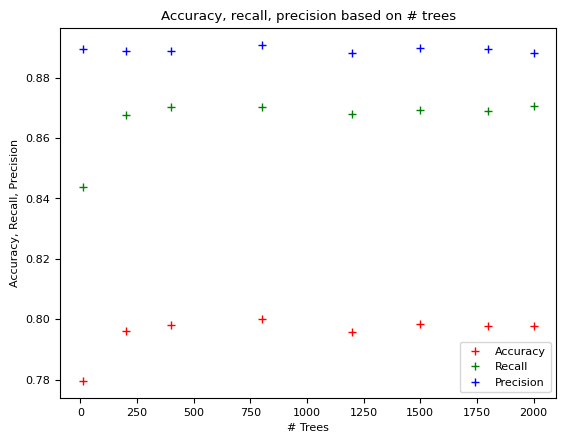

In [202]:

fig, ax = plt.subplots()

ax.plot(tree_sizes, acc_accumulated, "r+", label = "Accuracy")
ax.plot(tree_sizes, rec_accumulated, "g+", label = "Recall")
ax.plot(tree_sizes, prec_accumulated, "b+", label = "Precision")


ax.set(xlabel='# Trees', ylabel='Accuracy, Recall, Precision',
       title='Accuracy, recall, precision based on # trees')
ax.legend()

We can observe that using 800 trees provides the optimal accuracy, as well as precision, and there is no greater value for recall present as well (although being in par with 400 trees). Can we improve on the prediction values with further tuning of the tree depth?

In [205]:
tree_size = 800
tree_depths = [1, 2, 3, 4, 5, 6]
acc_accumulated = []
prec_accumulated = []
rec_accumulated = []
for tree_depth in tree_depths:
  penguin_RF_other_iter = RandomForestClassifier(n_estimators = tree_size, max_depth = tree_depth)
  xdata2 = ["Egg","Observed Lay Date","Other Lay Date","Other Hatch Date","Other Creche Date"]
  p_RF_fit_other_iter = penguin_RF_other_iter.fit(X_train_dates[xdata2], Y_train.values.ravel())

  p_RF_fit_other_iter.score(X_test_dates[xdata2],Y_test.values.ravel())

  penguin_RF_other_CV_iter = sklearn.model_selection.cross_validate(penguin_RF_other_iter, X_all_dates[xdata2], Y_all.values.ravel(), cv = 10, scoring=["accuracy", "recall", "precision"])
  acc = penguin_RF_other_CV_iter["test_accuracy"].mean()
  rec = penguin_RF_other_CV_iter["test_recall"].mean()
  prec = penguin_RF_other_CV_iter["test_precision"].mean()
  acc_accumulated.append(acc)
  prec_accumulated.append(prec)
  rec_accumulated.append(rec)

  print("Current depth: " + str(tree_depth))
  print("Mean test accuracy is: " + str(acc))
  print("Mean test recall is: " + str(rec))
  print("Mean test precision is: " + str(prec))

Current depth: 1
Mean test accuracy is: 0.8395751122246582
Mean test recall is: 1.0
Mean test precision is: 0.8395751122246582
Current depth: 2
Mean test accuracy is: 0.867681386366009
Mean test recall is: 0.9581167108753315
Mean test precision is: 0.8935526495523449
Current depth: 3
Mean test accuracy is: 0.8712297734627832
Mean test recall is: 0.9531152372531684
Mean test precision is: 0.9001462360830625
Current depth: 4
Mean test accuracy is: 0.8738104186240735
Mean test recall is: 0.9584806955496612
Mean test precision is: 0.8983428346024744
Current depth: 5
Mean test accuracy is: 0.8696158262866687
Mean test recall is: 0.9515576186265842
Mean test precision is: 0.8990555387048321
Current depth: 6
Mean test accuracy is: 0.8618738908027976
Mean test recall is: 0.9484733274388448
Mean test precision is: 0.8939807667613218


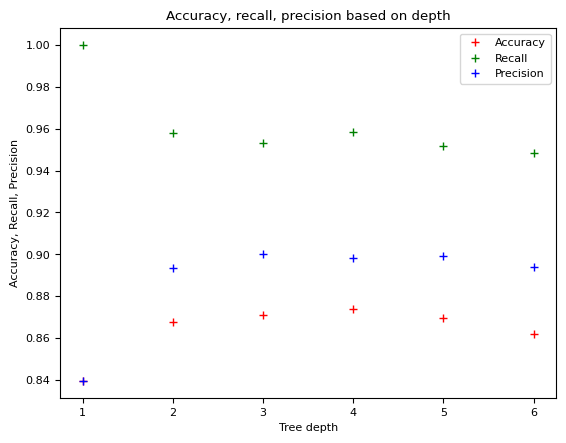

In [207]:
fig, ax = plt.subplots()

ax.plot(tree_depths, acc_accumulated, "r+", label = "Accuracy")
ax.plot(tree_depths, rec_accumulated, "g+", label = "Recall")
ax.plot(tree_depths, prec_accumulated, "b+", label = "Precision")

ax.set(xlabel='Tree depth', ylabel='Accuracy, Recall, Precision', title='Accuracy, recall, precision based on depth')
ax.legend()

Fixing the depth of individual trees in our RF does contribute to an increase in accuracy, while precision and recall vary depending on the other one. We observe the optimal value for mean accuracy for a preset depth of 4 (approx. 0.87, with mean recall of almost .96 and mean precision of just below .9).

Finally, one last option for avoiding overfitting would be min_samples_leaf. Let us observe the changes for the classifier when iterating over different values for this:

In [212]:
tree_size = 800
tree_depth = 4
min_samples_leafs = [1, 2, 3, 4, 5, 6, 8, 10]
acc_accumulated = []
prec_accumulated = []
rec_accumulated = []
for min_samples_leaf in min_samples_leafs:
  penguin_RF_other_iter = RandomForestClassifier(n_estimators = tree_size, max_depth = tree_depth, min_samples_leaf = min_samples_leaf)
  xdata2 = ["Egg","Observed Lay Date","Other Lay Date","Other Hatch Date","Other Creche Date"]
  p_RF_fit_other_iter = penguin_RF_other_iter.fit(X_train_dates[xdata2], Y_train.values.ravel())

  p_RF_fit_other_iter.score(X_test_dates[xdata2],Y_test.values.ravel())

  penguin_RF_other_CV_iter = sklearn.model_selection.cross_validate(penguin_RF_other_iter, X_all_dates[xdata2], Y_all.values.ravel(), cv = 10, scoring=["accuracy", "recall", "precision"])
  acc = penguin_RF_other_CV_iter["test_accuracy"].mean()
  rec = penguin_RF_other_CV_iter["test_recall"].mean()
  prec = penguin_RF_other_CV_iter["test_precision"].mean()
  acc_accumulated.append(acc)
  prec_accumulated.append(prec)
  rec_accumulated.append(rec)

  print("Current min_samples_leaf: " + str(min_samples_leaf))
  print("Mean test accuracy is: " + str(acc))
  print("Mean test recall is: " + str(rec))
  print("Mean test precision is: " + str(prec))

Current min_samples_leaf: 1
Mean test accuracy is: 0.8763910637853638
Mean test recall is: 0.9577114647804302
Mean test precision is: 0.9013404684606918
Current min_samples_leaf: 2
Mean test accuracy is: 0.8751007412047187
Mean test recall is: 0.9577085175361036
Mean test precision is: 0.9000230338658544
Current min_samples_leaf: 3
Mean test accuracy is: 0.8721975153982671
Mean test recall is: 0.9519451812555262
Mean test precision is: 0.9013197356249618
Current min_samples_leaf: 4
Mean test accuracy is: 0.8715523541079444
Mean test recall is: 0.9538653109342766
Mean test precision is: 0.8994641730992432
Current min_samples_leaf: 5
Mean test accuracy is: 0.8705846121724605
Mean test recall is: 0.9542469790745652
Mean test precision is: 0.8982685849553157
Current min_samples_leaf: 6
Mean test accuracy is: 0.8738104186240735
Mean test recall is: 0.9588623636899498
Mean test precision is: 0.898188098060111
Current min_samples_leaf: 8
Mean test accuracy is: 0.8738104186240735
Mean test rec

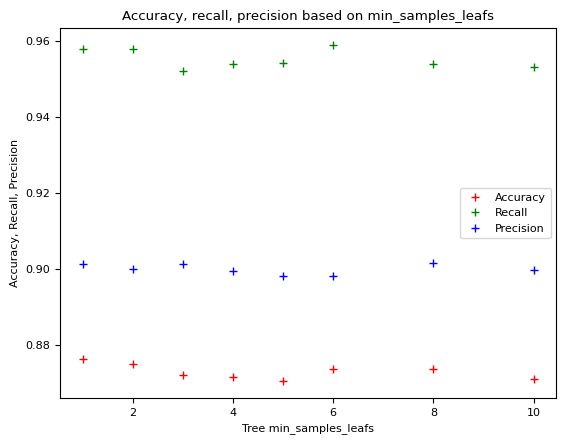

In [213]:
fig, ax = plt.subplots()

ax.plot(min_samples_leafs, acc_accumulated, "r+", label = "Accuracy")
ax.plot(min_samples_leafs, rec_accumulated, "g+", label = "Recall")
ax.plot(min_samples_leafs, prec_accumulated, "b+", label = "Precision")

ax.set(xlabel='Tree min_samples_leafs', ylabel='Accuracy, Recall, Precision', title='Accuracy, recall, precision based on min_samples_leafs')
ax.legend()

Limiting the min_sample_leafs to 1 seems to be the best choice, which yields us mean test accuracy of ca. 0.88, mean recall of ca. 0.96 and mean precision of ca. 0.90.

So, compared to the 2nd GAM (CV test accuracy 0.8834784424261406,
CV test recall 0.9625577071731121,
CV test precision 0.907186734014617), the results are on par!

And with that, we have tuned our parameters so to get a respectable prediction accuracy while dropping our best predictor, which is the observed hatching of a penguin egg. Let us do a final feature ranking for the classifier trained like this:

Text(20.000000000000014, 0.5, 'Mean decrease in impurity')

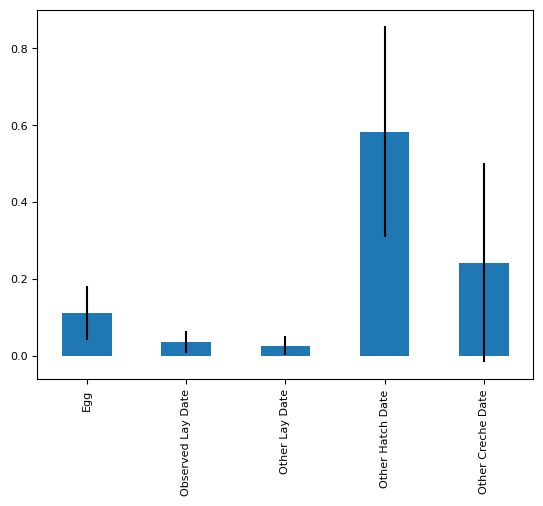

In [216]:
penguin_RF_other_final = RandomForestClassifier(n_estimators = 800, max_depth = 4, min_samples_leaf = 1)
xdata2 = ["Egg","Observed Lay Date","Other Lay Date","Other Hatch Date","Other Creche Date"]
p_RF_fit_other_final = penguin_RF_other_iter.fit(X_train_dates[xdata2], Y_train.values.ravel())

p_RF_other_importances = p_RF_fit_other_final.feature_importances_
p_RF_other_importance = pd.Series(p_RF_other_importances, index=xdata2)
std2 = np.std([tree.feature_importances_ for tree in p_RF_fit_other_final.estimators_], axis=0)
fig2, ax2 = plt.subplots()

p_RF_other_importance.plot.bar(yerr=std2, ax=ax2)

ax.set_ylabel("Mean decrease in impurity")

Text(0, 0.5, 'Mean accuracy decrease')

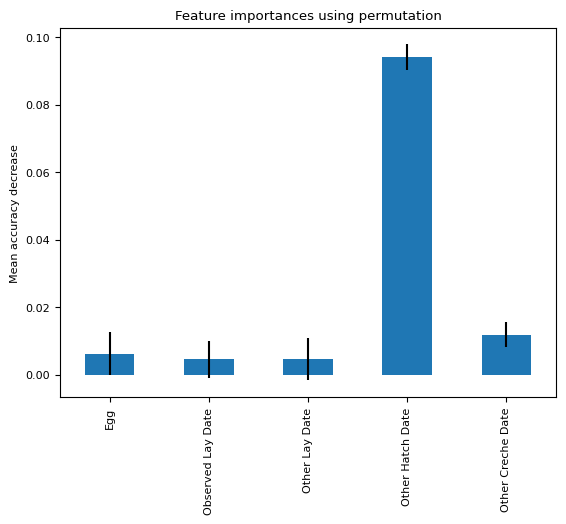

In [217]:
p_perm_importance_other_final = permutation_importance(p_RF_fit_other_final, X_test_dates[xdata2], Y_test, n_repeats=10)
forest_importances_other_final = pd.Series(p_perm_importance_other_final.importances_mean, index=xdata2)
fig, ax = plt.subplots()
forest_importances_other_final.plot.bar(yerr=p_perm_importance_other_final.importances_std, ax=ax)
ax.set_title("Feature importances using permutation")
ax.set_ylabel("Mean accuracy decrease")

That is a rather interesting result: Both approaches only agree in the other hatch date - with the result on the mean impurity decrease indicating observed lay date and egg as signficantly different from zero, whereas the mean accuracy decrease would only further indicate the other creche date.

How do we perform on the static and not really representative arbitrary test data set split earlier?

In [243]:
predict_dates = p_RF_fit_other_final.predict(X_test_dates[xdata2])
conf_dates = sklearn.metrics.confusion_matrix(Y_test, predict_dates)
conf_dates


array([[ 52,  54],
       [ 16, 498]])

Text(0.5, 27.52222222222222, 'Observed')

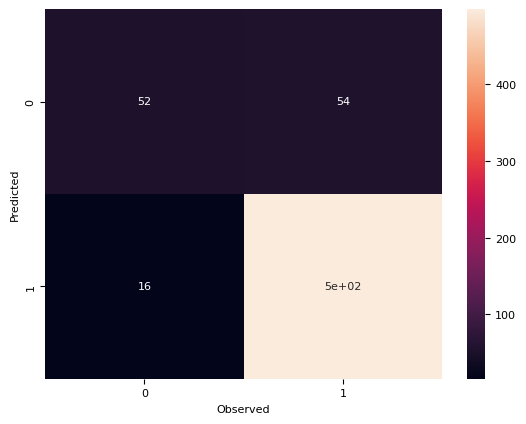

In [244]:
plt.plot()
sns.heatmap(conf_dates, annot=True)
plt.ylabel("Predicted")
plt.xlabel("Observed")

In [245]:
TP = conf_dates[0][0]
FP = conf_dates[1][0]
FN = conf_dates[0][1]
TN = conf_dates[1][1]
prec = TP/(TP+FP)
rec = TP/(TP+FN)
print("Recall is " +str(rec) +" and precision is: " +str(prec))

Recall is 0.49056603773584906 and precision is: 0.7647058823529411


So, compared to the 2nd GAM construced (Recall 0.25471698113207547, precision  0.9642857142857143), we did improve on our recall at the cost of precision. We are still misclassifying half of our negative cases! But that is just for the arbitrary test data set not using cross-validation and merely is to illustrate how misleading this approach could be in view of the data imbalance!


# Conclusion

## What we have learned

From this project, we have seen that penguin creching prediction primarily depends on one parameter - whether and when an egg under observation successfully hatches! With that, we can construct models having prediction accuracy of 1 on the test data, independent of whether we choose a GAM or a RF. We also learned that the outcome for the sibling, whether present or not present (!), influences the crèching outcome, and we have constructed a RF model, which, with parameter tuning, can predict crèching with an accuracy of 0.88, mean recall of ca. 0.96 and mean precision of ca. 0.90 without using the hatching of the egg under observation, which is on par with the 2nd GAM created as a reference.

What is more surprising is that merely using a sibling egg and the date of laying gives us a good chance of successfully predicting whether a penguin under observation will reach crèching age. Also this result is nicely inuitive considering the adaption to their environment lead to penguins laying usually two eggs.

## What did not work as planned

There are two major aspects that did not turn out as planned. The first was discovered even before assembling the models. We do not have any good way of solving the problem of conditional probabilities hiding in the data: If we observe a second egg, this is conditional on a first being layed. If we observe crèching of the other egg, it means that it succesfully hatched. While we split the data into separate observations with a corresponding Egg indicator, this does not alleviate the hidden conditional probabilities, and dropping predictors would also not have helped as discussed above. As such, it is unsurprising that we observe that both other hatch and other crèching are similarily relevant, as other crèching is dependent on the outcome of other hatching. The use of a RF classifier being able to choose the feature to take into account should have lessened the impact of this, but it falls short of a more comprehensive (and time-consuming) analysis of the correlation of the features in the dataset.



Secondly, it was not intended to work with a dataset so biased towards a single predictor - our data is sufficiently explained with only the hatching of the egg under observation. This does render most tuning of any model trained on the full data set rather meaningless.

## Future work

What we could do to address the issue of conditional probabilities is further pre-processing the data set in the EDA, performing more comprehensive statistical analysis before creating our models on the data. One way of certainly reducing these issues is decoupling the state of whether a certain phase (egg layed, hatched, crèching) was reached from the numerical date, e. g. by having a three-level categorical indicator (layed, hatched, crèched) extracted. This would however depend on the numeric value. This conundrum cannot be completely solved, unless partial dropping of features would be performed. One could built a RF that restricts access to only one of respective correlated features for the same tree for building the RF.

We cannot do much about the fact that our sole predictor is sufficient - we could only have chosen another data set, which would have required hindsight of said outcome.